# Supply Chain Anomaly Detection Demo
    
This notebook demonstrates the complete workflow of the Supply Chain Anomaly Detection system using a sample dataset. It walks through:

1. Creating sample data
2. Data preprocessing and feature engineering,
3. Anomaly detection,
4. Issue classification,
5. Recommendation generation,
6. Visualization and analysis,

Let's start by importing necessary libraries and setting up our environment.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add the project root to Python path to import our package
# This assumes the notebook is in the notebooks/ directory
sys.path.append(r"D:\DS\supply-chain-anomaly-detection-master")

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)

# Import our main class
from src.models.sc_issue_detection import SupplyChainIssueDetection

# Optional: Import MLflow utilities if available
try:
    from mlflow import mlflow_utils
    MLFLOW_AVAILABLE = True
except ImportError:
    MLFLOW_AVAILABLE = False
    print("MLflow not available. Install with 'pip install mlflow' for experiment tracking.")

MLflow not available. Install with 'pip install mlflow' for experiment tracking.


## 1. Load Data

### 1.1. Generate Sample Data

First, let's create a sample dataset for supply chain metrics. We'll create a dataset with some known anomalies to demonstrate the detection capabilities.

In [2]:
def create_sample_data(n_records=50, seed=42):
    """Create a sample dataset with supply chain metrics."""
    np.random.seed(seed)  # For reproducibility
    
    # Define sample values for categorical features
    skus = [f"SKU_{i}" for i in range(1, 6)]
    countries = ['US', 'UK', 'DE']
    quarters = ['2024Q1', '2024Q2']
    
    # Create base data
    data = pd.DataFrame({
        'SKU': np.random.choice(skus, n_records),
        'Country': np.random.choice(countries, n_records),
        'Quarter': np.random.choice(quarters, n_records),
        'SellThru': np.random.randint(100, 1000, n_records),
        'SellTo': np.random.randint(80, 950, n_records),
        'T2Inventory': np.random.randint(200, 2000, n_records),
        'DistributorInventory': np.random.randint(100, 1500, n_records),
        'Backlog': np.random.randint(0, 500, n_records),
        'Shipments': np.random.randint(50, 800, n_records),
        'AgedInventory': np.random.randint(0, 300, n_records),
        'WeeksOfStockT1': np.random.uniform(1, 10, n_records),
        'WeeksOfStockT2': np.random.uniform(2, 12, n_records),
        'NumCompetitors': np.random.randint(1, 10, n_records),
        'PricePositioning': np.random.uniform(80, 120, n_records),
        'TargetQty': np.random.randint(200, 1200, n_records)
    })
    
    # Introduce some anomalies (around 10%)
    anomaly_indices = np.random.choice(n_records, size=5, replace=False)
    
    # Inventory imbalances
    data.loc[anomaly_indices[0], 'WeeksOfStockT1'] = 15
    
    # Sales performance gaps
    data.loc[anomaly_indices[1], 'SellTo'] = int(data.loc[anomaly_indices[1], 'TargetQty'] * 0.4)
    
    # Pricing issues
    data.loc[anomaly_indices[2], 'PricePositioning'] = 130
    
    # Supply chain disruptions
    data.loc[anomaly_indices[3], 'Backlog'] = 800
    
    # Sell-through bottlenecks
    data.loc[anomaly_indices[4], 'SellThru'] = int(data.loc[anomaly_indices[4], 'SellTo'] * 0.5)
    
    return data
    
# Create the sample data
sample_data = create_sample_data(n_records=50)

# Create directory for data if it doesn't exist
os.makedirs('D:/DS/supply-chain-anomaly-detection/src/data/sample/', exist_ok=True)

# Save the sample data
sample_data_path = 'D:/DS/supply-chain-anomaly-detection/src/data/sample/sample_supply_chain_data.csv'
sample_data.to_csv(sample_data_path, index=False)

print(f"Sample data created with shape: {sample_data.shape}")
sample_data.head()

Sample data created with shape: (50, 15)


,SKU,Country,Quarter,SellThru,SellTo,T2Inventory,DistributorInventory,Backlog,Shipments,AgedInventory,WeeksOfStockT1,WeeksOfStockT2,NumCompetitors,PricePositioning,TargetQty
0,SKU_4,DE,2024Q1,963,535,446,445,370,165,57,4.203754,3.181648,9,118.772101,1022
1,SKU_5,DE,2024Q1,842,490,1035,723,469,240,179,7.820615,8.967372,1,100.923914,717
2,SKU_3,US,2024Q1,340,728,1662,1116,374,302,169,15.000000,8.289428,6,105.175946,675
3,SKU_5,DE,2024Q1,663,397,402,980,21,210,270,2.044654,10.774720,7,107.829948,1176
4,SKU_5,DE,2024Q2,195,756,1407,101,237,305,53,1.414024,9.350710,8,98.181643,908


## 2. Initialize and Configure the Supply Chain Issue Detection System

Now, let's initialize our anomaly detection system. We'll configure it with parameters suitable for our sample dataset.

In [3]:
# Initialize the detector
# Note: Set use_llm=True if you have an OpenAI API key and want LLM-enhanced recommendations
detector = SupplyChainIssueDetection(
    use_llm=False,  # Set to True if you have an OpenAI API key in environment
    contamination=0.3,  # We expect about 30% anomalies in our sample data
    random_state=42  # For reproducibility
)

print("Supply Chain Issue Detection system initialized")

2025-07-21 19:42:11,700 - src.models.anomaly_detection - INFO - Anomaly detector initialized with contamination 0.3
2025-07-21 19:42:11,702 - src.models.issue_classification - INFO - Issue classifier initialized
2025-07-21 19:42:11,703 - src.models.recommendation - INFO - Recommendation generator initialized with rule-based recommendations only
2025-07-21 19:42:11,704 - src.models.sc_issue_detection - INFO - Supply Chain Issue Detection system initialized


Supply Chain Issue Detection system initialized


## 3. Start MLflow Tracking (Optional)

If MLflow is available, we'll use it to track our experiment.

In [4]:
# Start MLflow tracking if available
if MLFLOW_AVAILABLE:
    mlflow_run = mlflow_utils.start_run(experiment_name="supply_chain_demo")
    
    # Log parameters
    params = {
        'contamination': 0.1,
        'random_state': 42,
        'use_llm': False,
        'data_source': 'sample_data'
    }
    mlflow_utils.log_parameters(params)
    
    print(f"MLflow tracking started with run ID: {mlflow_run.info.run_id}")
else:
    print("MLflow tracking not available. Continuing without experiment tracking.")

MLflow tracking not available. Continuing without experiment tracking.


## 4. Data Processing Pipeline

Now, let's run through the entire pipeline steps using our sample data.

### 4.1 Load and Preprocess Data

In [6]:
# Load data
path='D:/DS/supply-chain-anomaly-detection/src/data/sample/sample_supply_chain_data.csv'
detector.data = detector.load_data(path)
print(f"Loaded data with shape: {detector.data.shape}")

# Preprocess data
processed_data = detector.preprocess_data()
print(f"Preprocessed data with shape: {processed_data.shape}")

# Show engineered features
engineered_features = [
    'SellThruToRatio', 
   'InventoryTurnoverRate', 
   'TargetAchievement',
   'SupplyChainEfficiency', 
    'AgedInventoryPct'
]

processed_data.describe()#[engineered_features].describe()

2025-07-21 19:42:20,435 - src.data.preprocess - INFO - Loaded CSV data from D:/DS/supply-chain-anomaly-detection/src/data/sample/sample_supply_chain_data.csv with shape: (50, 15)
2025-07-21 19:42:20,437 - src.data.preprocess - WARNING - Missing columns in data: SellThruToRatio, InventoryTurnoverRate, TargetAchievement, SupplyChainEfficiency, AgedInventoryPct
2025-07-21 19:42:20,485 - src.data.preprocess - INFO - Data preprocessing completed
2025-07-21 19:42:20,496 - src.data.preprocess - INFO - Engineered feature 'SellThruToRatio': mean=1.50, min=0.18, max=5.55
2025-07-21 19:42:20,498 - src.data.preprocess - INFO - Engineered feature 'InventoryTurnoverRate': mean=1.23, min=0.15, max=7.49
2025-07-21 19:42:20,501 - src.data.preprocess - INFO - Engineered feature 'TargetAchievement': mean=114.19, min=14.79, max=384.98
2025-07-21 19:42:20,503 - src.data.preprocess - INFO - Engineered feature 'SupplyChainEfficiency': mean=9.92, min=0.29, max=182.75
2025-07-21 19:42:20,505 - src.data.preproc

Loaded data with shape: (50, 15)
Preprocessed data with shape: (50, 20)


,SellThru,SellTo,T2Inventory,DistributorInventory,Backlog,Shipments,AgedInventory,WeeksOfStockT1,WeeksOfStockT2,NumCompetitors,PricePositioning,TargetQty,SellThruToRatio,InventoryTurnoverRate,TargetAchievement,SupplyChainEfficiency,AgedInventoryPct
count,50.000000,50.000000,50.000000,50.000000,50.000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,579.400000,562.500000,1047.120000,804.160000,239.480,419.720000,146.040000,5.146944,7.586799,5.040000,103.856952,681.980000,1.495097,1.231204,114.190357,9.917097,27.199875
std,245.116382,238.163916,536.334979,409.516208,170.094,228.339708,81.785174,3.018429,2.901258,2.539163,12.286388,309.441728,1.408111,1.566751,94.178830,30.299721,30.334755
min,127.000000,81.000000,322.000000,101.000000,3.000,67.000000,0.000000,1.163996,2.108377,1.000000,81.054679,200.000000,0.183526,0.153110,14.786418,0.286533,0.000000
25%,346.000000,361.000000,552.750000,458.000000,96.500,205.500000,88.750000,2.150093,5.316993,3.000000,95.102810,373.500000,0.583799,0.417707,52.781335,0.783094,10.202222
50%,632.000000,582.500000,1000.500000,907.500000,230.500,419.000000,125.500000,5.192761,8.011904,5.000000,104.670956,666.000000,0.944400,0.665031,77.667815,1.827732,16.257974
75%,774.250000,754.750000,1542.000000,1159.000000,365.500,618.000000,219.750000,6.893581,10.005055,7.000000,114.403106,956.500000,1.779592,1.185758,138.466026,3.545552,30.331211
max,999.000000,934.000000,1994.000000,1427.000000,800.000,784.000000,289.000000,15.000000,11.905051,9.000000,130.000000,1196.000000,5.545455,7.485149,384.978541,182.750000,180.555556


### 4.2 Detect Anomalies

In [7]:
processed_data.columns

Index(['SKU', 'Country', 'Quarter', 'SellThru', 'SellTo', 'T2Inventory',
       'DistributorInventory', 'Backlog', 'Shipments', 'AgedInventory',
       'WeeksOfStockT1', 'WeeksOfStockT2', 'NumCompetitors',
       'PricePositioning', 'TargetQty', 'SellThruToRatio',
       'InventoryTurnoverRate', 'TargetAchievement', 'SupplyChainEfficiency',
       'AgedInventoryPct'],
      dtype='object')

In [9]:
# Train anomaly detector
detector.train_anomaly_detector()

# Count anomalies
anomaly_count = detector.data['is_anomaly'].sum()
print(f"Detected {anomaly_count} anomalies out of {len(detector.data)} records ({anomaly_count/len(detector.data)*100:.1f}%)")

# Look at model agreement
agreement_df = pd.DataFrame({
    'Isolation Forest': detector.data['if_anomaly'],
    'LOF': detector.data['lof_anomaly'] if 'lof_anomaly' in detector.data.columns else np.zeros(len(detector.data)),
    'One-Class SVM': detector.data['ocsvm_anomaly'],
   'Ensemble Decision': detector.data['is_anomaly'],
   'Anomaly Score': detector.data['anomaly_score']
})

# Display anomalies
anomalies_df = detector.data[detector.data['is_anomaly'] == 1].copy()
anomalies_df[['SKU', 'Country', 'Quarter', 'SellThruToRatio', 
            'InventoryTurnoverRate', 
            'TargetAchievement', 
            'SupplyChainEfficiency', 
            'AgedInventoryPct', 'anomaly_score']]

2025-07-21 19:43:55,794 - src.models.anomaly_detection - INFO - Fitting anomaly detection models on 50 samples with 22 features
2025-07-21 19:43:56,009 - src.models.anomaly_detection - INFO - Ensemble anomaly detection completed. Found 14 anomalies out of 50 records.


Detected 14 anomalies out of 50 records (28.0%)


,SKU,Country,Quarter,SellThruToRatio,InventoryTurnoverRate,TargetAchievement,SupplyChainEfficiency,AgedInventoryPct,anomaly_score
4,SKU_5,DE,2024Q2,0.257937,7.485149,21.475771,1.281513,52.475248,0.584119
10,SKU_4,UK,2024Q1,0.935982,0.706157,381.981982,1.413242,0.311769,0.518247
12,SKU_5,UK,2024Q2,0.359521,6.953704,35.340314,0.917603,180.555556,0.982647
16,SKU_4,UK,2024Q1,0.335927,2.511401,91.843972,2.405594,87.296417,0.362253
17,SKU_5,UK,2024Q1,4.885417,0.153110,272.674419,2.103093,9.808612,0.388058
20,SKU_2,UK,2024Q1,0.355086,3.405229,28.201220,0.341518,95.424837,0.403245
24,SKU_1,UK,2024Q2,0.740406,4.364532,74.208145,0.289474,44.827586,0.330013
26,SKU_3,US,2024Q1,1.598712,0.345185,76.725026,182.750000,16.888889,0.913974
27,SKU_2,UK,2024Q1,4.661458,0.155466,138.759690,16.771429,9.392713,0.357033
30,SKU_3,UK,2024Q1,4.093750,0.634921,95.342067,32.647059,50.793651,0.348586


### 4.3 Visualize Anomalies

Key Insights:
- Critical stock-outs (<1 week) are associated with poor target achievement
- Overstocking (>7 weeks) indicates potential forecasting issues
- Optimal inventory levels fall between 2-5 weeks of stock
- Clustering of anomalies reveals distinct supply chain problem patterns

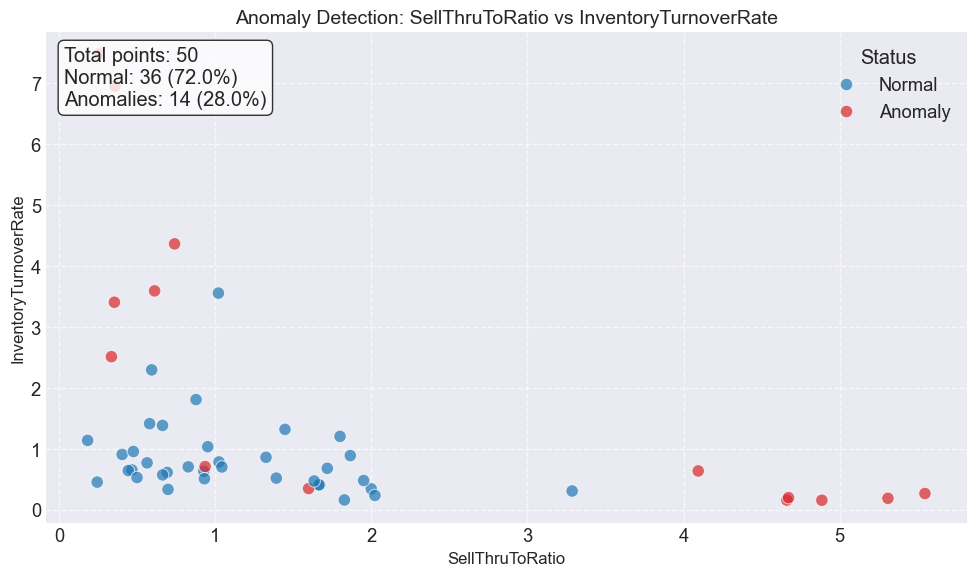

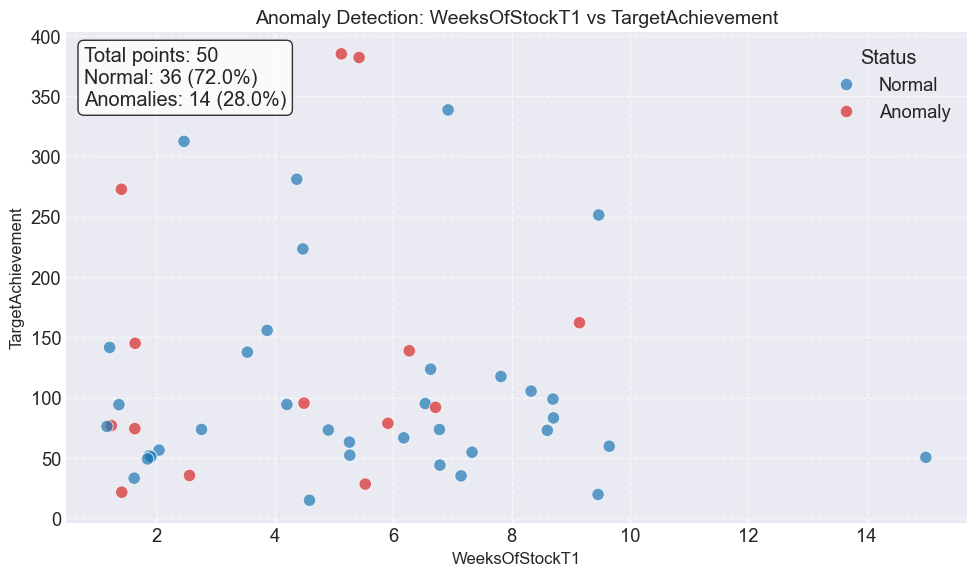

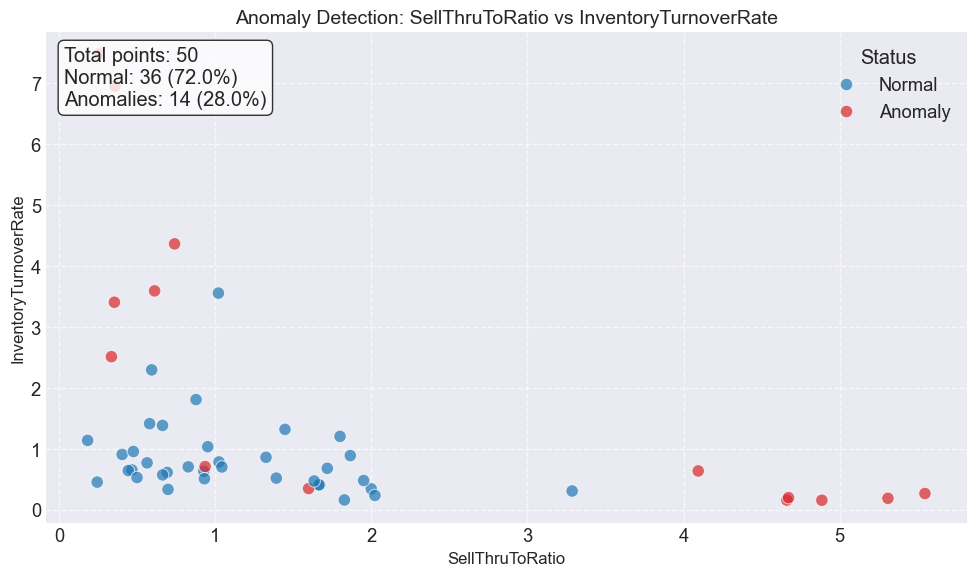

In [10]:
# Visualize anomalies by WeeksOfStock vs TargetAchievement
detector.visualize_anomalies('WeeksOfStockT1', 'TargetAchievement')

# Visualize anomalies by SellThruToRatio vs InventoryTurnoverRate
detector.visualize_anomalies('SellThruToRatio', 'InventoryTurnoverRate')

### 4.4 Classify Issues

2025-07-21 19:45:28,668 - src.models.issue_classification - INFO - Rule-based issue classification completed
2025-07-21 19:45:28,670 - src.models.issue_classification - INFO - Issue Type Distribution:
issue_type
Sell_Through_Bottleneck    5
Supply_Chain_Disruption    4
Unknown                    3
Pricing_Issue              2
Name: count, dtype: int64
2025-07-21 19:45:28,683 - src.models.issue_classification - INFO - Rule-based issue classification completed
2025-07-21 19:45:28,685 - src.models.issue_classification - INFO - Issue Type Distribution:
issue_type
Sell_Through_Bottleneck    5
Supply_Chain_Disruption    4
Unknown                    3
Pricing_Issue              2
Name: count, dtype: int64
2025-07-21 19:45:28,688 - src.models.issue_classification - INFO - Class distribution before balancing: {'Sell_Through_Bottleneck': 5, 'Pricing_Issue': 2, 'Supply_Chain_Disruption': 4, 'Unknown': 3}
2025-07-21 19:45:28,694 - src.models.issue_classification - ERROR - Error during ML classific

Issue Type Distribution:
issue_type
Sell_Through_Bottleneck    5
Supply_Chain_Disruption    4
Unknown                    3
Pricing_Issue              2
Name: count, dtype: int64


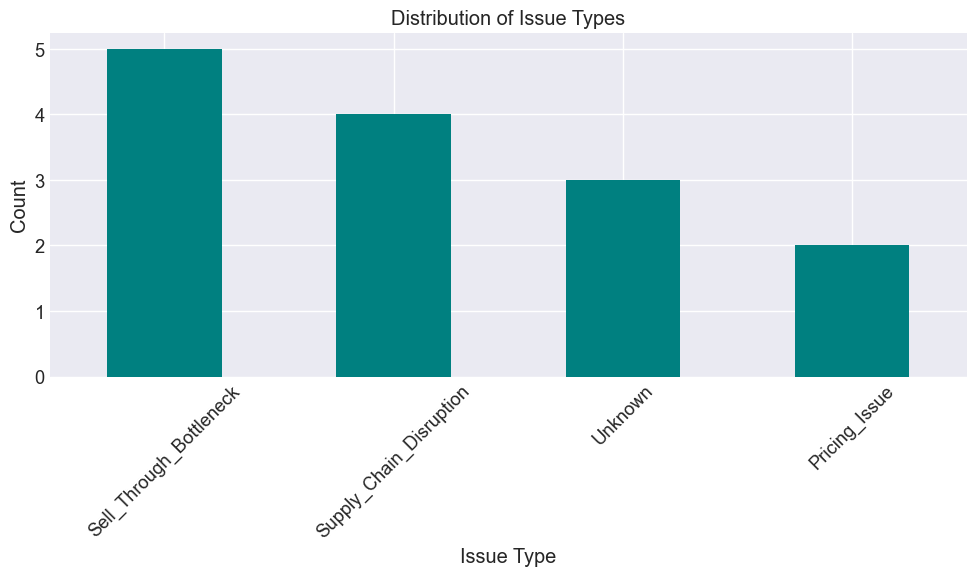

,SKU,Country,Quarter,issue_type,anomaly_score
4,SKU_5,DE,2024Q2,Sell_Through_Bottleneck,0.584119
10,SKU_4,UK,2024Q1,Pricing_Issue,0.518247
12,SKU_5,UK,2024Q2,Sell_Through_Bottleneck,0.982647
16,SKU_4,UK,2024Q1,Sell_Through_Bottleneck,0.362253
17,SKU_5,UK,2024Q1,Supply_Chain_Disruption,0.388058
20,SKU_2,UK,2024Q1,Sell_Through_Bottleneck,0.403245
24,SKU_1,UK,2024Q2,Unknown,0.330013
26,SKU_3,US,2024Q1,Supply_Chain_Disruption,0.913974
27,SKU_2,UK,2024Q1,Supply_Chain_Disruption,0.357033
30,SKU_3,UK,2024Q1,Supply_Chain_Disruption,0.348586


In [12]:
# Classify issues
classified_anomalies = detector.classify_issues(use_ml=True)

# Display issue distribution
issue_counts = classified_anomalies['issue_type'].value_counts()
print("Issue Type Distribution:")
print(issue_counts)

# Plot issue distribution
plt.figure(figsize=(10, 6))
issue_counts.plot(kind='bar', color='teal')
plt.title('Distribution of Issue Types')
plt.xlabel('Issue Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display classified anomalies
classified_anomalies[['SKU', 'Country', 'Quarter','issue_type', 'anomaly_score']]

### 4.5 Generate Recommendations

In [13]:
# Generate recommendations
recommendations = detector.generate_recommendations(classified_anomalies)

# Display recommendations
recommendations[['SKU', 'Country', 'Quarter', 'Issue_Type', 'Priority', 'Final_Recommendation']]

2025-07-21 19:45:47,059 - src.models.recommendation - INFO - Generated recommendations for 14 anomalies


,SKU,Country,Quarter,Issue_Type,Priority,Final_Recommendation
4,SKU_5,DE,2024Q2,Sell_Through_Bottleneck,Medium,Channel partner for distributor Unknown Distri...
10,SKU_4,UK,2024Q1,Pricing_Issue,Medium,Adjust pricing strategy for distributor Unknow...
12,SKU_5,UK,2024Q2,Sell_Through_Bottleneck,High,Channel partner for distributor Unknown Distri...
16,SKU_4,UK,2024Q1,Sell_Through_Bottleneck,Medium,Channel partner for distributor Unknown Distri...
17,SKU_5,UK,2024Q1,Supply_Chain_Disruption,Medium,Address backlog issues for distributor Unknown...
20,SKU_2,UK,2024Q1,Sell_Through_Bottleneck,Medium,Channel partner for distributor Unknown Distri...
24,SKU_1,UK,2024Q2,Unknown,Medium,Investigate unclassified anomaly for distribut...
26,SKU_3,US,2024Q1,Supply_Chain_Disruption,High,Address backlog issues for distributor Unknown...
27,SKU_2,UK,2024Q1,Supply_Chain_Disruption,Medium,Address backlog issues for distributor Unknown...
30,SKU_3,UK,2024Q1,Supply_Chain_Disruption,Medium,Address backlog issues for distributor Unknown...


### 4.6 PCA Visualization and Analysis

In [14]:
detector.data=recommendations

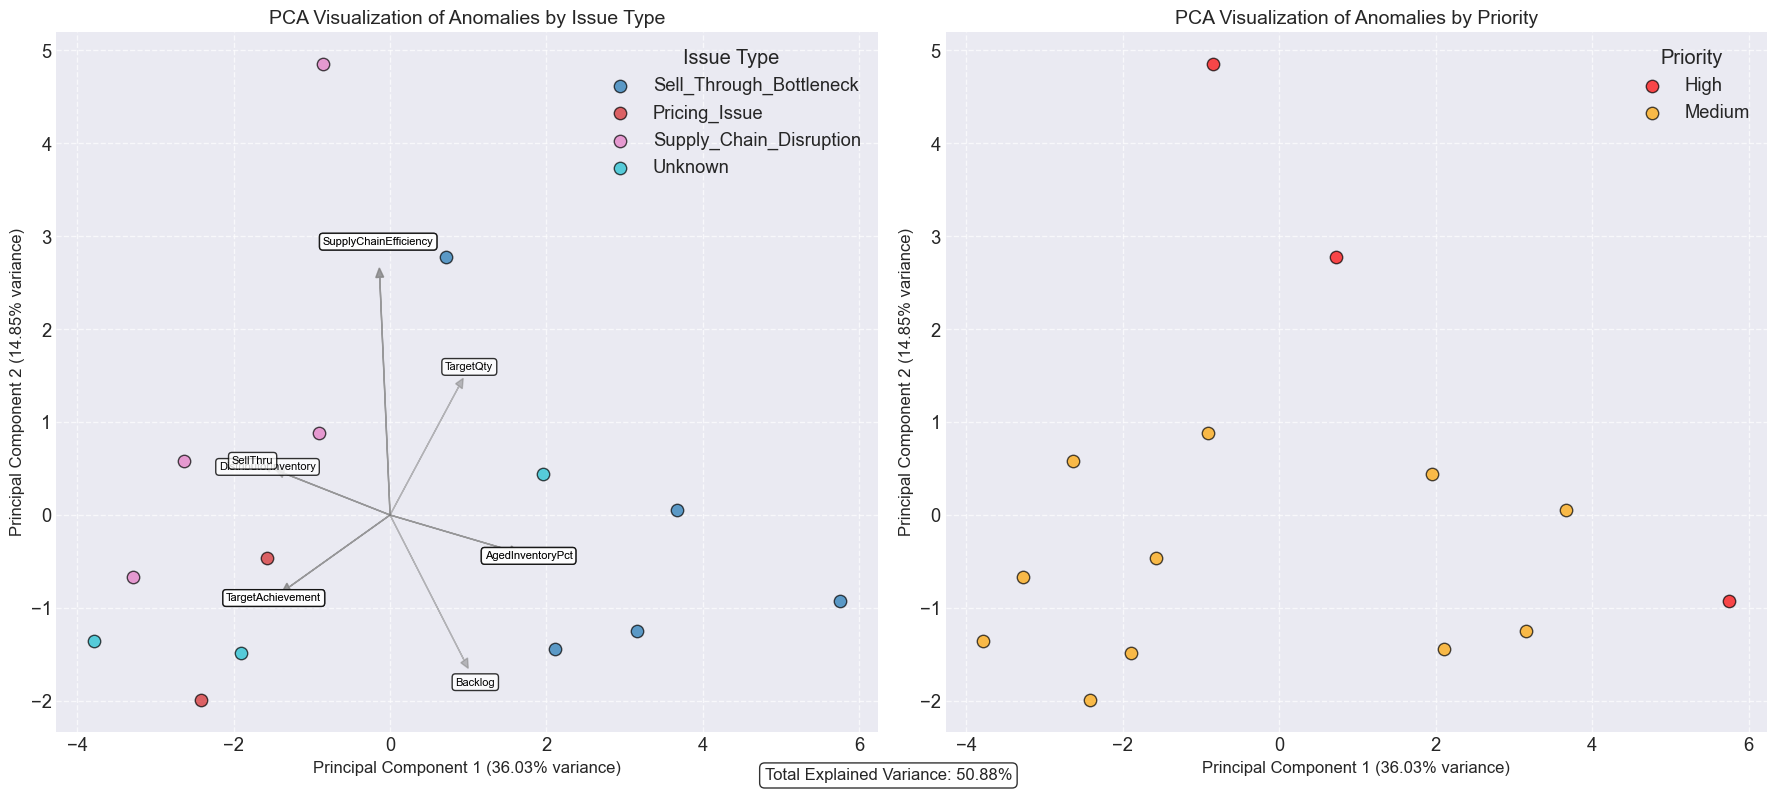

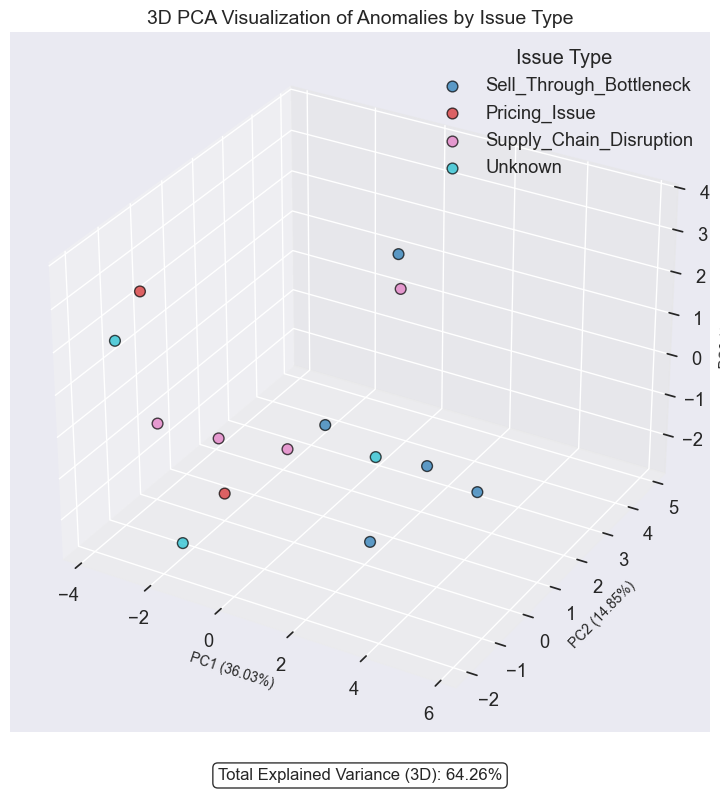

2025-07-21 19:45:59,917 - src.visualization.visualize - INFO - PCA visualization created with 14 anomalies and 4 issue types
2025-07-21 19:45:59,943 - src.visualization.visualize - INFO - 
PCA Analysis for Issue Categorization Validation:
2025-07-21 19:45:59,944 - src.visualization.visualize - INFO - Total explained variance: 50.88%
2025-07-21 19:45:59,946 - src.visualization.visualize - INFO - Issue types identified: 4
2025-07-21 19:45:59,947 - src.visualization.visualize - INFO - Silhouette score: -0.030
2025-07-21 19:45:59,947 - src.visualization.visualize - INFO - Separation quality: Poor separation between issue types
2025-07-21 19:45:59,948 - src.visualization.visualize - INFO - 
Top features driving categorization:
2025-07-21 19:45:59,949 - src.visualization.visualize - INFO -   - Feature_15: 0.538
2025-07-21 19:45:59,949 - src.visualization.visualize - INFO -   - Feature_20: 0.538
2025-07-21 19:45:59,950 - src.visualization.visualize - INFO -   - Feature_4: 0.502
2025-07-21 19:

Total explained variance: 50.88%
Silhouette score: -0.030
Separation quality: Poor separation between issue types

Top features driving categorization:
  - Feature_15: 0.538
  - Feature_20: 0.538
  - Feature_4: 0.502
  - Feature_11: 0.453
  - Feature_19: 0.414


In [15]:
# Visualize using PCA
pca, pca_anomalies = detector.visualize_with_pca()

# Analyze PCA results
pca_analysis = detector.analyze_pca_results(pca, pca_anomalies)

# Print key insights
print(f"Total explained variance: {pca_analysis['total_explained_variance']:.2f}%")
if pca_analysis['silhouette_score'] is not None:
    print(f"Silhouette score: {pca_analysis['silhouette_score']:.3f}")
print(f"Separation quality: {pca_analysis['separation_quality']}")

print("\nTop features driving categorization:")
top_features = sorted(pca_analysis['feature_importance'], key=lambda x: x['Total_Importance'], reverse=True)[:5]
for feature in top_features:
    print(f"  - {feature['Feature']}: {feature['Total_Importance']:.3f}")

## 5. Save Models and Results

In [16]:
# Create output directory if it doesn't exist
os.makedirs('D:/DS/supply-chain-anomaly-detection-master/models', exist_ok=True)

# Save models
model_path = 'D:/DS/supply-chain-anomaly-detection-master/models' +'/demo_supply_chain_model'
detector.save_models(model_path)
print(f"Models saved to {model_path}")

# Save recommendations to CSV
os.makedirs('D:/DS/supply-chain-anomaly-detection-master/data/processed', exist_ok=True)
recommendations.to_csv('D:/DS/supply-chain-anomaly-detection-master/data/processed/demo_recommendations.csv', index=False)
print("Recommendations saved to ../data/processed/demo_recommendations.csv")

# Log to MLflow if available
if MLFLOW_AVAILABLE:
    # Log metrics
    metrics = {
        'anomaly_count': anomaly_count,
        'anomaly_percentage': anomaly_count/len(detector.data)*100
    }
    
    # Add issue type counts
    for issue, count in issue_counts.items():
        metrics[f'issue_count_{issue}'] = count
    
    # Add PCA metrics if available
    if pca_analysis:
        metrics['pca_explained_variance'] = pca_analysis['total_explained_variance']
        if pca_analysis['silhouette_score'] is not None:
            metrics['silhouette_score'] = pca_analysis['silhouette_score']
    
    mlflow_utils.log_metrics(metrics)
    
    # Log recommendations as artifact
    mlflow_utils.log_dataframe(recommendations, 'recommendations', 'csv')
    
    # Log model
    mlflow_utils.log_model(detector, "supply_chain_detector")
    
    print("Results logged to MLflow")

2025-07-21 19:48:19,754 - src.data.preprocess - INFO - Preprocessor state saved to D:/DS/supply-chain-anomaly-detection-master/models/demo_supply_chain_model_preprocessor.pkl
2025-07-21 19:48:19,836 - src.models.anomaly_detection - INFO - Anomaly detection models saved to D:/DS/supply-chain-anomaly-detection-master/models/demo_supply_chain_model_anomaly_model.pkl
2025-07-21 19:48:19,837 - src.models.issue_classification - WARNING - No trained classifier to save
2025-07-21 19:48:19,839 - src.models.sc_issue_detection - INFO - Models and configuration saved with prefix: D:/DS/supply-chain-anomaly-detection-master/models/demo_supply_chain_model


Models saved to D:/DS/supply-chain-anomaly-detection-master/models/demo_supply_chain_model
Recommendations saved to ../data/processed/demo_recommendations.csv


## 7. End MLflow Run (if started)

In [0]:
# End MLflow run if it was started
if MLFLOW_AVAILABLE and 'mlflow_run' in locals():
    mlflow_run.__exit__(None, None, None)
    print("MLflow run ended")

## 8. Summary and Conclusions

In this notebook, we've demonstrated the complete workflow of the Supply Chain Anomaly Detection system:

1. **Data Processing**: We loaded and preprocessed supply chain data, creating engineered features to improve anomaly detection.

2. **Anomaly Detection**: Using an ensemble approach that combines multiple algorithms (Isolation Forest, LOF, One-Class SVM), we identified anomalous patterns in the data.

3. **Issue Classification**: We categorized the detected anomalies into specific issue types such as Inventory Imbalance, Sales Performance Gap, Pricing Issue, etc.

4. **Recommendation Generation**: For each anomaly, we generated tailored recommendations to address the underlying issues.

5. **Visualization and Analysis**: We created visualizations to understand anomalies and their patterns, and used PCA to validate issue categorization quality.

6. **Model Management**: We saved the models for future use and demonstrated how to load them for processing new data.

7. **MLflow Integration**: We showed how MLflow can be used to track experiments, metrics, and models.

This end-to-end workflow demonstrates the capabilities of the Supply Chain Anomaly Detection system for identifying and addressing issues in supply chain operations.